In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plot_feature_importances(model):
    n_features = X_train_processed.shape[1]
    plt.figure(figsize=(12,50))
    plt.barh(range(n_features), model.feature_importances_, align='edge') 
    plt.yticks(np.arange(n_features), X_train_processed.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')



In [3]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    '''takes in true values and predicted values.
    The function then prints out a classifcation report
    as well as a confusion matrix using seaborn's heatmap.'''
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat, average = 'weighted')
    recall = recall_score(y, y_hat, average = 'weighted')
    accuracy = accuracy_score(y,y_hat)
    print(classification_report(y, y_hat))
    print('Accurancy: ', accuracy)
    sns.heatmap(cm,  cmap= 'Greens', annot=True)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title(title)
    plt.show()

In [4]:
train = pd.read_csv('../data/processed_data.csv')
train.permit = train.permit.astype(str)

In [5]:
X = train.drop(['id', 'status_group', 'status', 'date_recorded'], axis=1)
y = train.status
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
ohe_features = ['funder/installer', 'region_bins',
               'public_meeting', 'lga_coded',
               'scheme_management/management', 'permit', 
               'extraction_type/group/class', 
               'payment', 'quality_group',
               'quantity', 'source_type', 'waterpoint_type/group']

In [7]:
cont_features = ['gps_height', 'population'
                 ]

decade_features = ['2000-2010', '1990-2000', '1980-1990',
                   '2010-2020', '1970-1980', '1960-1970']

In [8]:
X_train_ohe = X_train[ohe_features]
X_test_ohe = X_test[ohe_features]
X_train_cont = X_train[cont_features].astype(float)
X_test_cont = X_test[cont_features].astype(float)

In [9]:
X_train_index = X_train.index
X_test_index = X_test.index

In [10]:
ohe = OneHotEncoder()
ss = StandardScaler()
X_train_encoded = ohe.fit_transform(X_train_ohe)
X_test_encoded = ohe.transform(X_test_ohe)
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_cont), columns=X_train[cont_features].columns, index=X_train_index)
X_test_scaled = pd.DataFrame(ss.transform(X_test_cont), columns=X_test[cont_features].columns, index=X_test_index)

In [11]:
train_columns = ohe.get_feature_names(input_features=X_train_ohe.columns)
test_columns = ohe.get_feature_names(input_features=X_test_ohe.columns)
X_train_processed = pd.DataFrame(X_train_encoded.todense(), columns=train_columns, index=X_train_index)
X_test_processed = pd.DataFrame(X_test_encoded.todense(), columns=test_columns, index=X_test_index)

In [12]:
X_train_all = pd.concat([X_train_scaled, X_train_processed], axis=1)
X_test_all = pd.concat([X_test_scaled, X_test_processed], axis=1)


In [13]:
X_train_all = X_train_all.join(X_train[decade_features])
X_test_all = X_test_all.join(X_test[decade_features])

In [14]:
X_train_all.isna().sum()

gps_height                  0
population                  0
funder/installer_adb/dwe    0
funder/installer_amref      0
funder/installer_binned     0
                           ..
1990-2000                   0
1980-1990                   0
2010-2020                   0
1970-1980                   0
1960-1970                   0
Length: 144, dtype: int64

In [15]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train_all, y_train)

RandomForestClassifier(n_estimators=1000)

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      5678
           1       0.48      0.33      0.39      1074
           2       0.80      0.86      0.83      8098

    accuracy                           0.78     14850
   macro avg       0.69      0.65      0.67     14850
weighted avg       0.78      0.78      0.78     14850

Accurancy:  0.7837710437710438


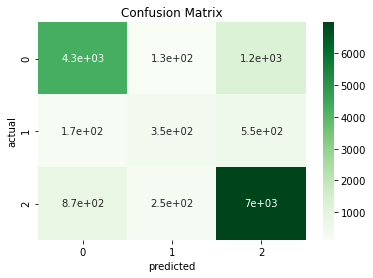

In [16]:
evaluation(y_test, rf.predict(X_test_all))

In [17]:
confusion_matrix(y_train, rf.predict(X_train_all))

array([[16039,   105,  1002],
       [  116,  2617,   510],
       [  442,   150, 23569]], dtype=int64)

In [18]:
confusion_matrix(y_test, rf.predict(X_test_all))

array([[4307,  132, 1239],
       [ 171,  354,  549],
       [ 870,  250, 6978]], dtype=int64)

In [19]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_processed, y_train)

MultinomialNB()

In [24]:
rf = RandomForestClassifier()


In [36]:
confusion_matrix(y_test, rf.predict(X_test_all))

array([[4238,  125, 1315],
       [ 169,  343,  562],
       [ 824,  265, 7009]], dtype=int64)

In [25]:
bc = BaggingClassifier(base_estimator=rf, n_estimators=)
bc.fit(X_train_all, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier())

In [26]:
confusion_matrix(y_test, bc.predict(X_test_all))

array([[4286,  100, 1292],
       [ 165,  330,  579],
       [ 792,  189, 7117]], dtype=int64)

In [28]:
param_grid={'n_estimators': [10,50],
             'warm_start': [False, True]}

gs = GridSearchCV(bc, param_grid, cv=3)



In [29]:
gs.fit(X_train_all, y_train)

GridSearchCV(cv=3,
             estimator=BaggingClassifier(base_estimator=RandomForestClassifier()),
             param_grid={'n_estimators': [10, 50], 'warm_start': [False, True]})

In [32]:
gs.best_params_

{'n_estimators': 50, 'warm_start': False}

In [33]:
gs.best_score_

0.7881930415263749

In [34]:
from sklearn.ensemble import GradientBoostingClassifier


In [37]:
gb = GradientBoostingClassifier()

param_grid={'n_estimators': [100,500],
             'max_depth': [3,5]}
gs = GridSearchCV(gb, param_grid, cv=3, verbose=10)

In [38]:
gs.fit(X_train_all, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] max_depth=3, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... max_depth=3, n_estimators=100, score=0.751, total=  32.1s
[CV] max_depth=3, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.0s remaining:    0.0s


[CV] ....... max_depth=3, n_estimators=100, score=0.754, total=  31.8s
[CV] max_depth=3, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] ....... max_depth=3, n_estimators=100, score=0.750, total=  31.8s
[CV] max_depth=3, n_estimators=500 ...................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s


[CV] ....... max_depth=3, n_estimators=500, score=0.768, total= 2.6min
[CV] max_depth=3, n_estimators=500 ...................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.2min remaining:    0.0s


[CV] ....... max_depth=3, n_estimators=500, score=0.771, total= 2.7min
[CV] max_depth=3, n_estimators=500 ...................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.9min remaining:    0.0s


[CV] ....... max_depth=3, n_estimators=500, score=0.768, total= 2.7min
[CV] max_depth=5, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  9.5min remaining:    0.0s


[CV] ....... max_depth=5, n_estimators=100, score=0.767, total=  53.4s
[CV] max_depth=5, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 10.4min remaining:    0.0s


[CV] ....... max_depth=5, n_estimators=100, score=0.771, total=  53.3s
[CV] max_depth=5, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 11.3min remaining:    0.0s


[CV] ....... max_depth=5, n_estimators=100, score=0.764, total=  53.0s
[CV] max_depth=5, n_estimators=500 ...................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 12.2min remaining:    0.0s


[CV] ....... max_depth=5, n_estimators=500, score=0.780, total=10.2min
[CV] max_depth=5, n_estimators=500 ...................................
[CV] ....... max_depth=5, n_estimators=500, score=0.780, total= 4.2min
[CV] max_depth=5, n_estimators=500 ...................................
[CV] ....... max_depth=5, n_estimators=500, score=0.779, total= 4.4min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 31.0min finished


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [3, 5], 'n_estimators': [100, 500]},
             verbose=10)

In [39]:
gs.best_score_

0.7799999999999999

In [40]:
gs.best_params_

{'max_depth': 5, 'n_estimators': 500}

In [44]:
gs.best_estimator_.feature_importances_()

TypeError: 'numpy.ndarray' object is not callable

In [47]:
plot_feature_importances(bc)

AttributeError: 'BaggingClassifier' object has no attribute 'feature_importances_'

<Figure size 864x3600 with 0 Axes>